In [85]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.adefc_2dm as adefc
import apra_pop_models.efc_utils as efc_utils

from scipy.optimize import minimize

Nwaves = 9
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
est_waves = bandpasses[:, Nwaves_per_bp//2]
print(est_waves)

dm1_flat = utils.load_fits('dm1_flat_command.fits')

[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]
[6.25625e-07 6.50000e-07 6.74375e-07]


In [36]:
bandpasses.flatten()

array([6.337500e-07, 6.378125e-07, 6.418750e-07, 6.459375e-07,
       6.500000e-07, 6.540625e-07, 6.581250e-07, 6.621875e-07,
       6.662500e-07])

In [83]:
np.random.randn(20)*2*u.nm + 5*u.nm

<Quantity [4.6163289 , 3.22474207, 3.50568341, 8.3849092 , 5.10161551,
           3.72600871, 5.38183097, 9.20051027, 5.2403179 , 6.23440622,
           5.60034064, 4.29550031, 2.7149636 , 4.30131456, 4.58221153,
           6.17324638, 6.67796683, 6.86220416, 5.57117465, 6.77028233] nm>

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


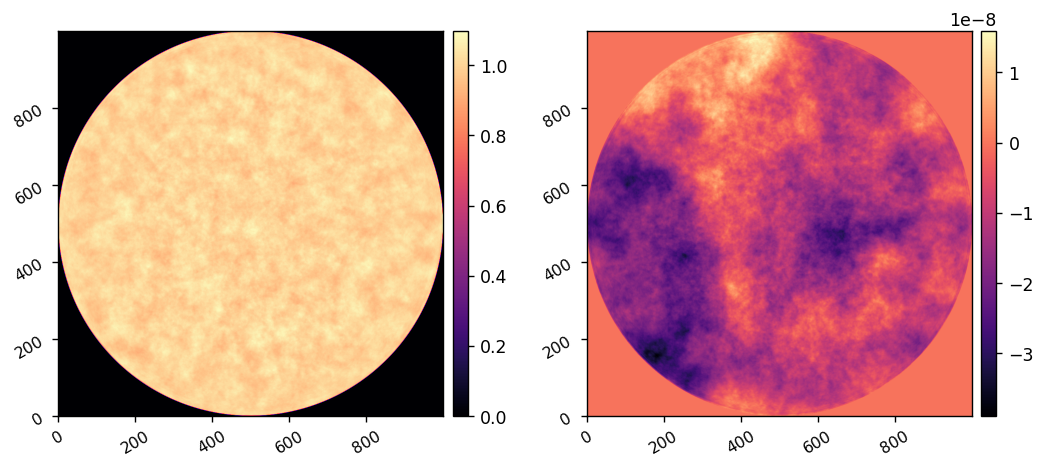

In [86]:
reload(fresnel)
I = fresnel.CORO(
    # dm1_ref=xp.rot90(xp.rot90(dm1_flat))
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

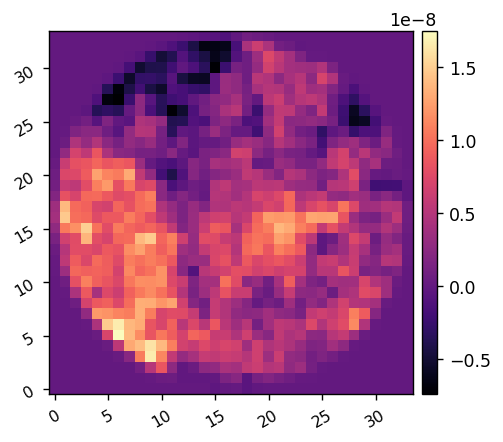

In [34]:
imshow1(dm1_flat)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


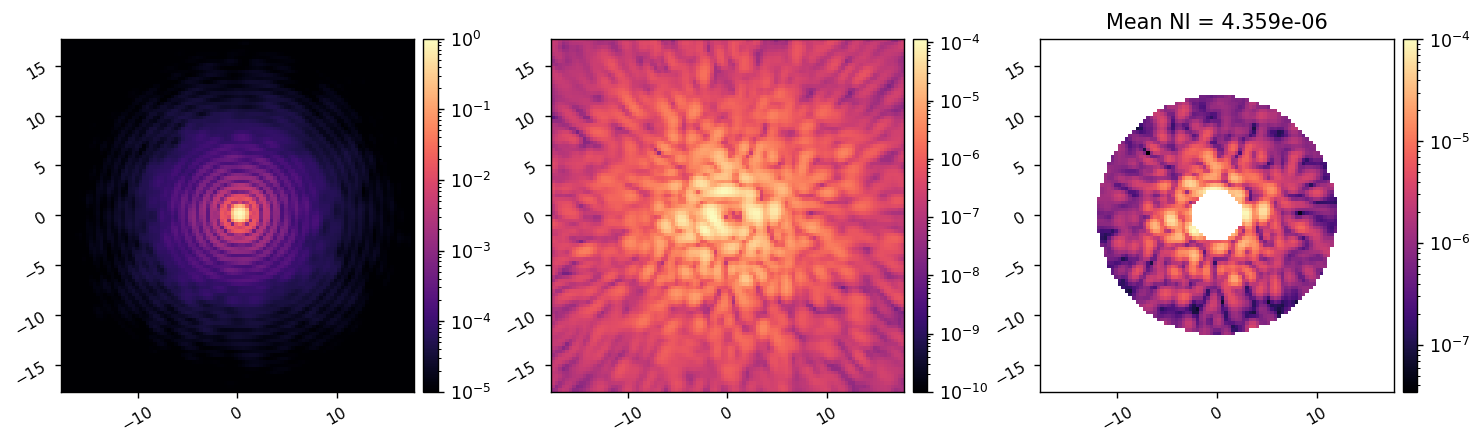

In [87]:
reload(fresnel)
I = fresnel.CORO(
    # dm1_ref=xp.rot90(xp.rot90(dm1_flat))
)
I.use_opds = True
I.bandpasses = bandpasses 

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

reload(efc_utils)
iwa = 2.5
owa = 12
rot = 0
control_mask = efc_utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'Mean NI = {mean_ni:.3e}', 
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


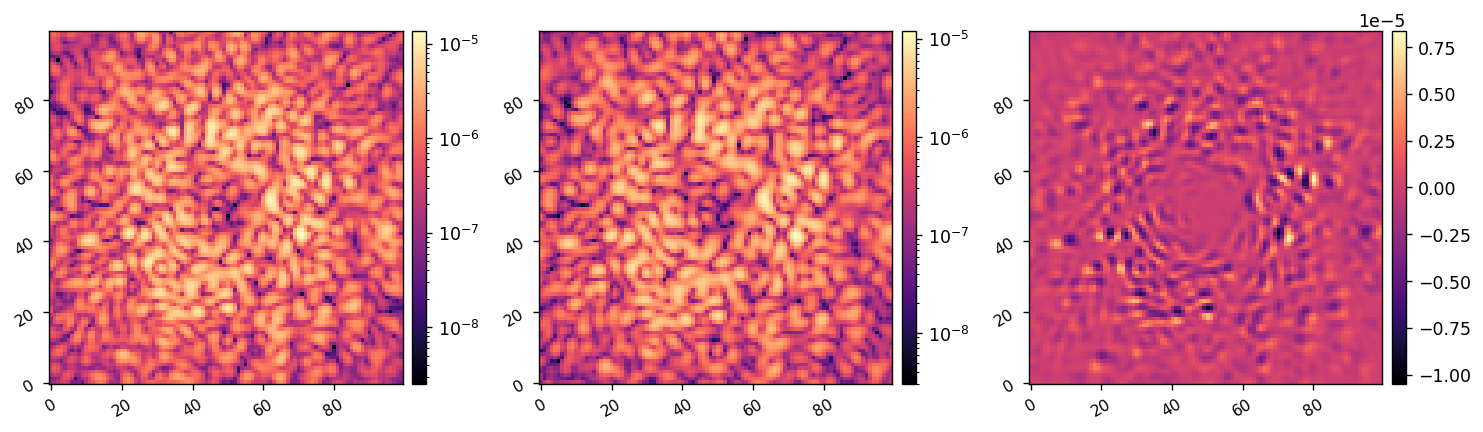

In [42]:
im_bp1 = I.snap(1)
im_bp3 = I.snap(3)
diff = im_bp3 - im_bp1
imshow3(im_bp1, im_bp3, diff, lognorm1=True, lognorm2=True, )

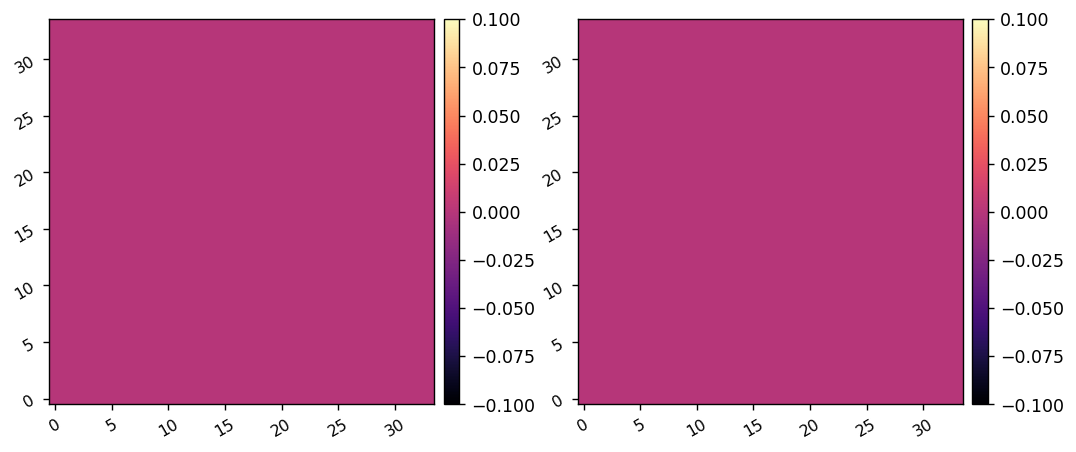

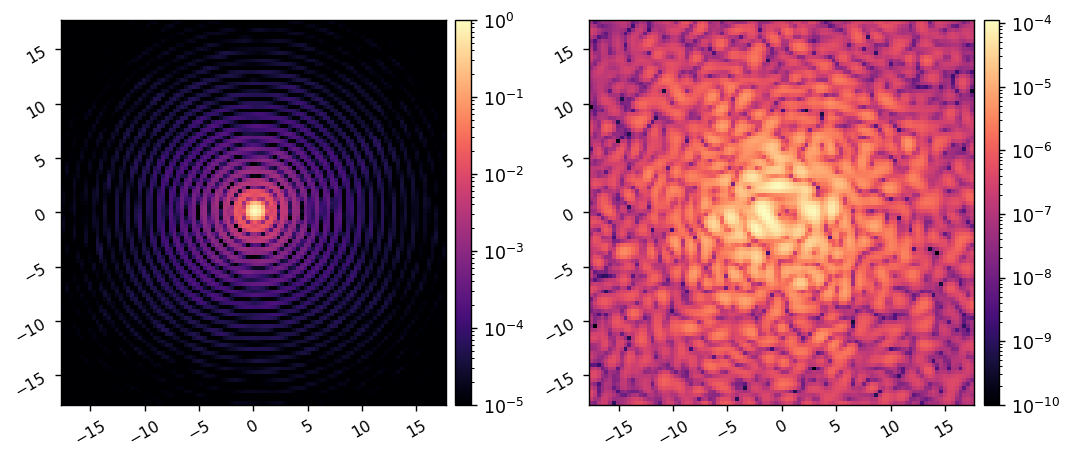

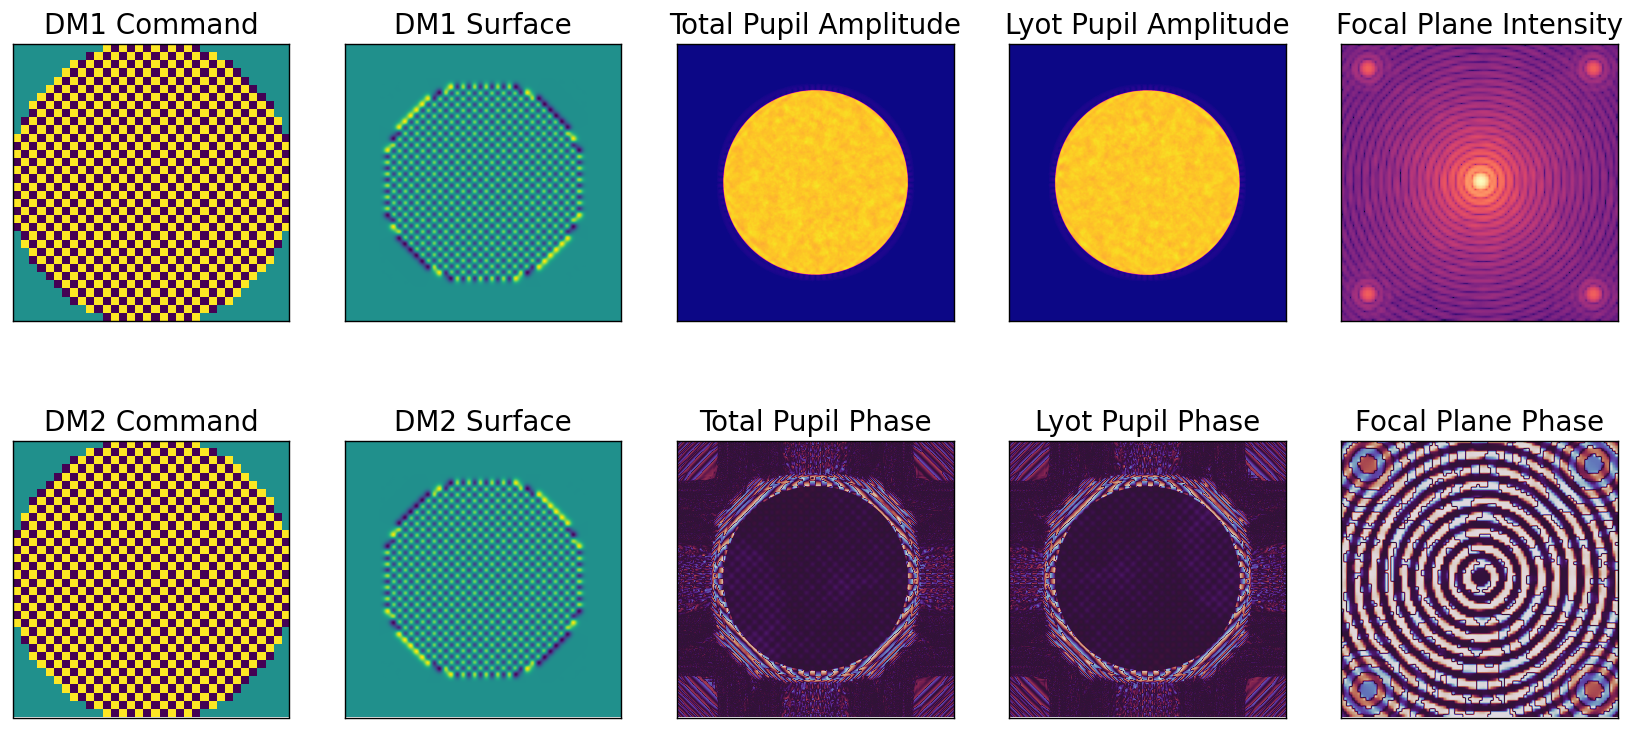

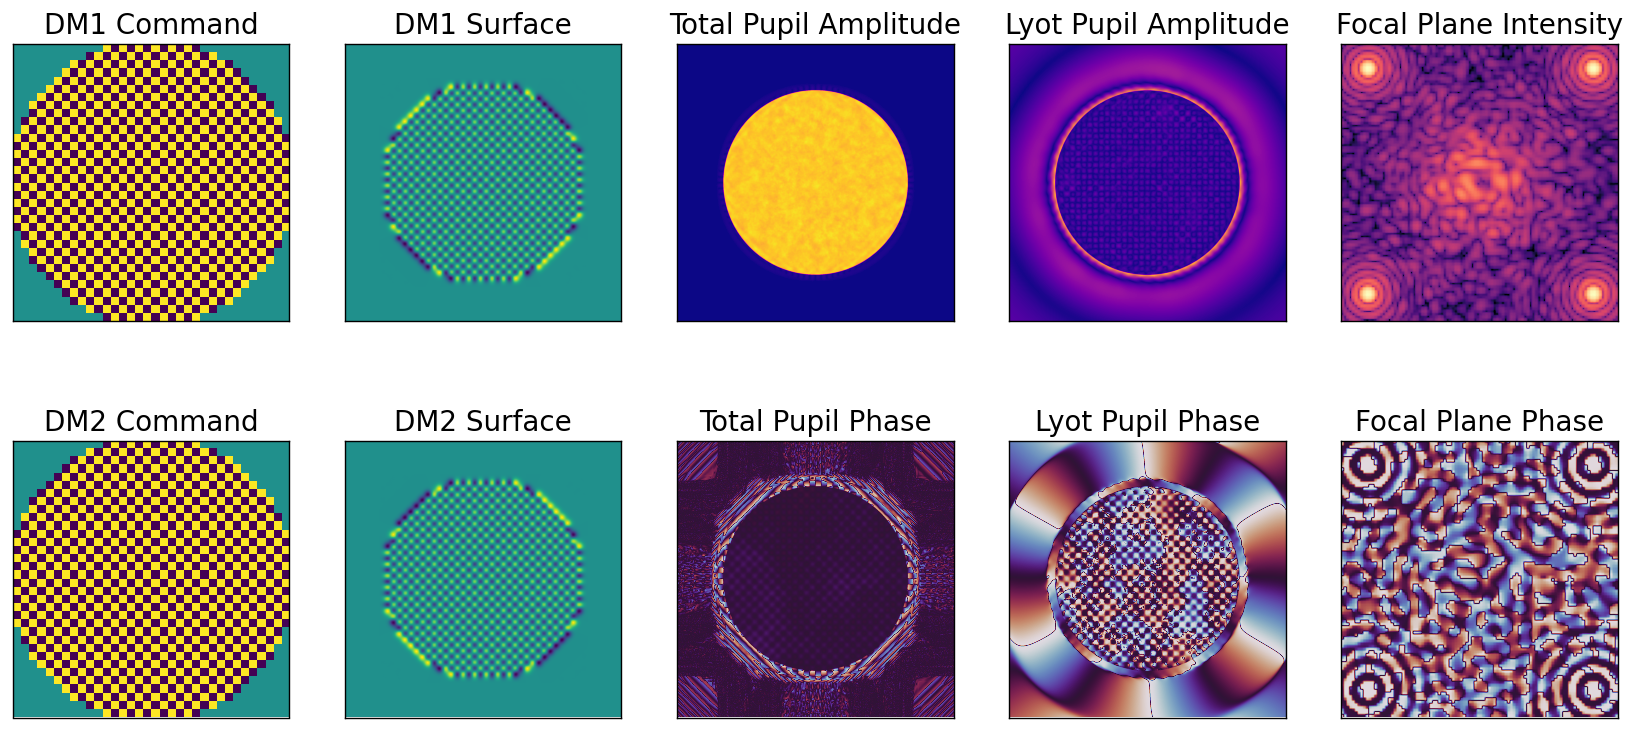

In [88]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

M.set_dm1(I.get_dm1())
M.set_dm2(I.get_dm2())
imshow2(M.get_dm1(), M.get_dm2())

M.setattr('use_vortex', False)
model_psf = xp.abs(M.calc_wf())**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

M.setattr('use_vortex', True)
model_coro_im = xp.abs(M.calc_wf())**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
# command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
dm1_command = 10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
dm2_command = -10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

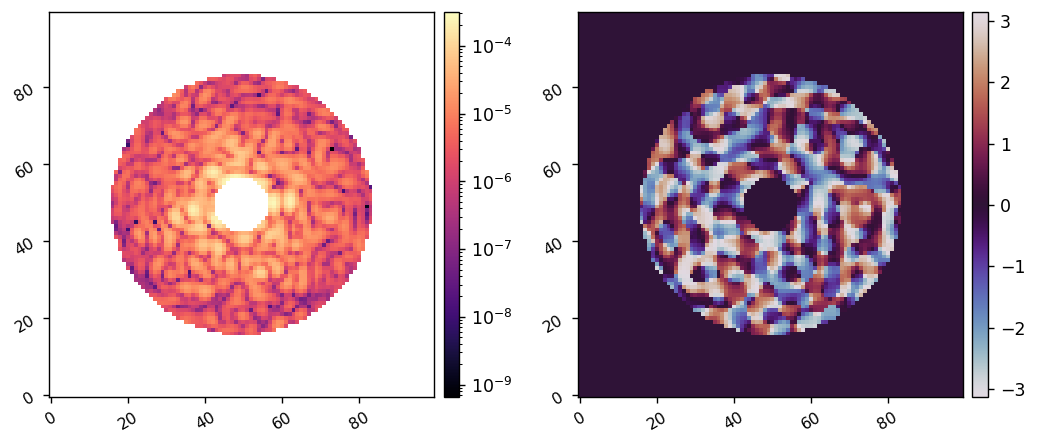

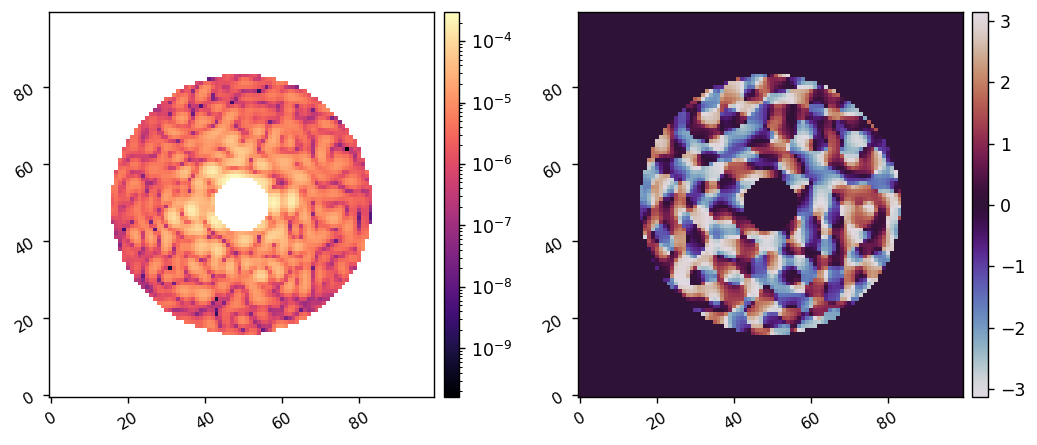

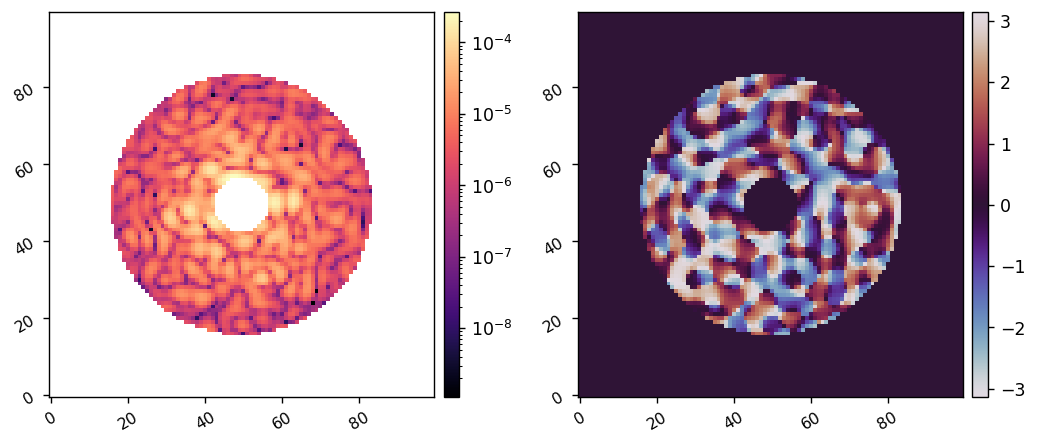

In [13]:
reload(adefc)
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)

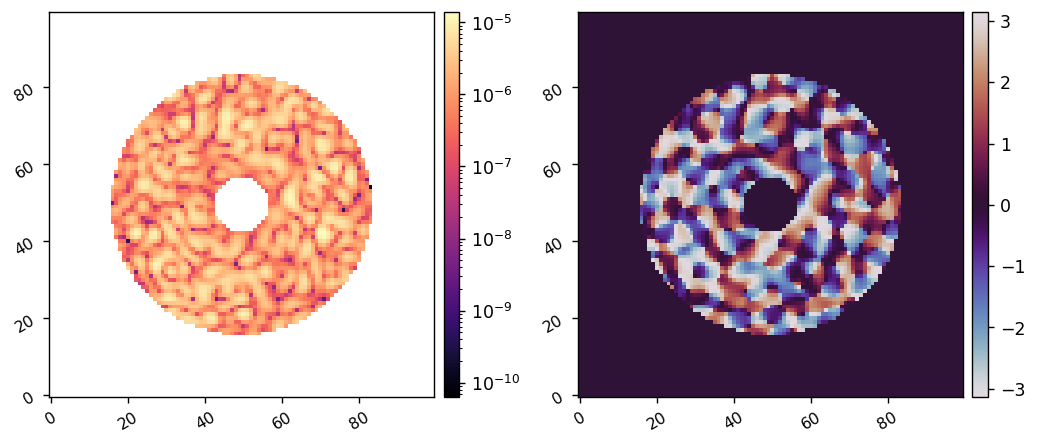

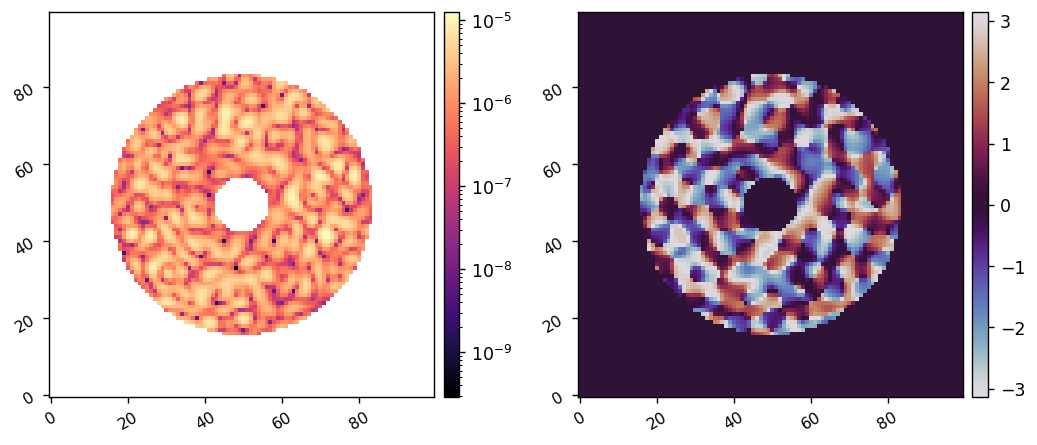

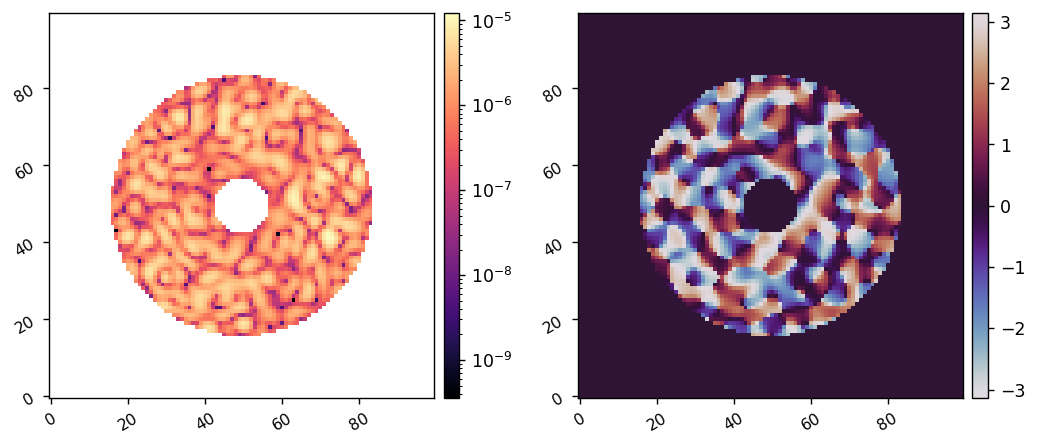

	Cost-function J_delE: 0.007
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 1.000

	Cost-function J_delE: 0.006
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 1.000

	Cost-function J_delE: 0.006
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 1.000



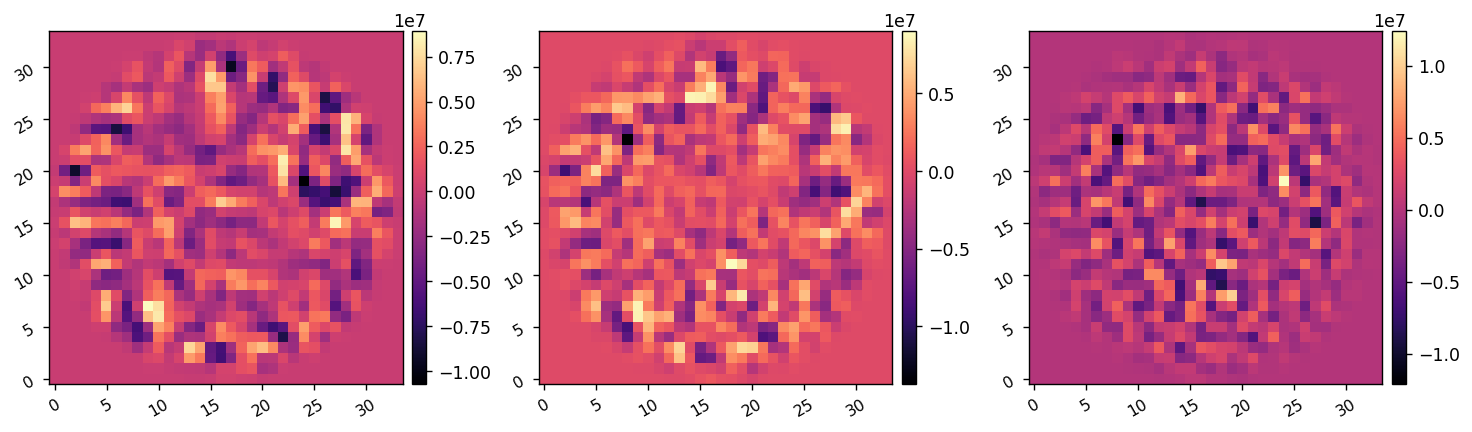

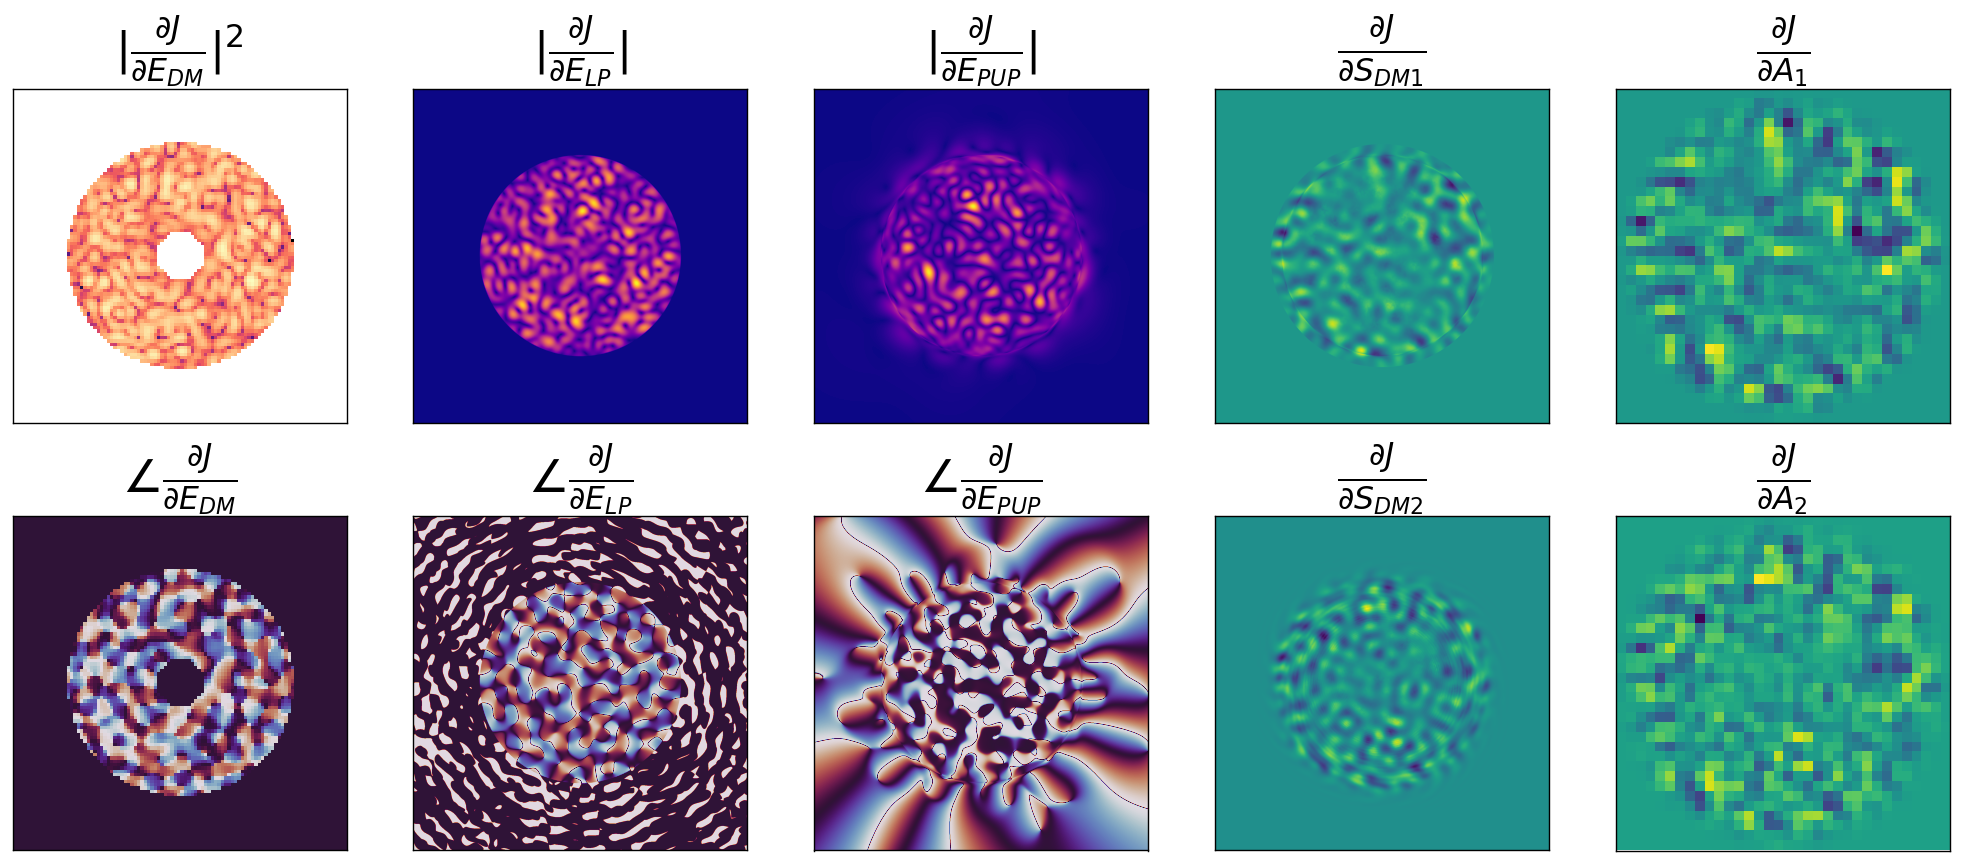

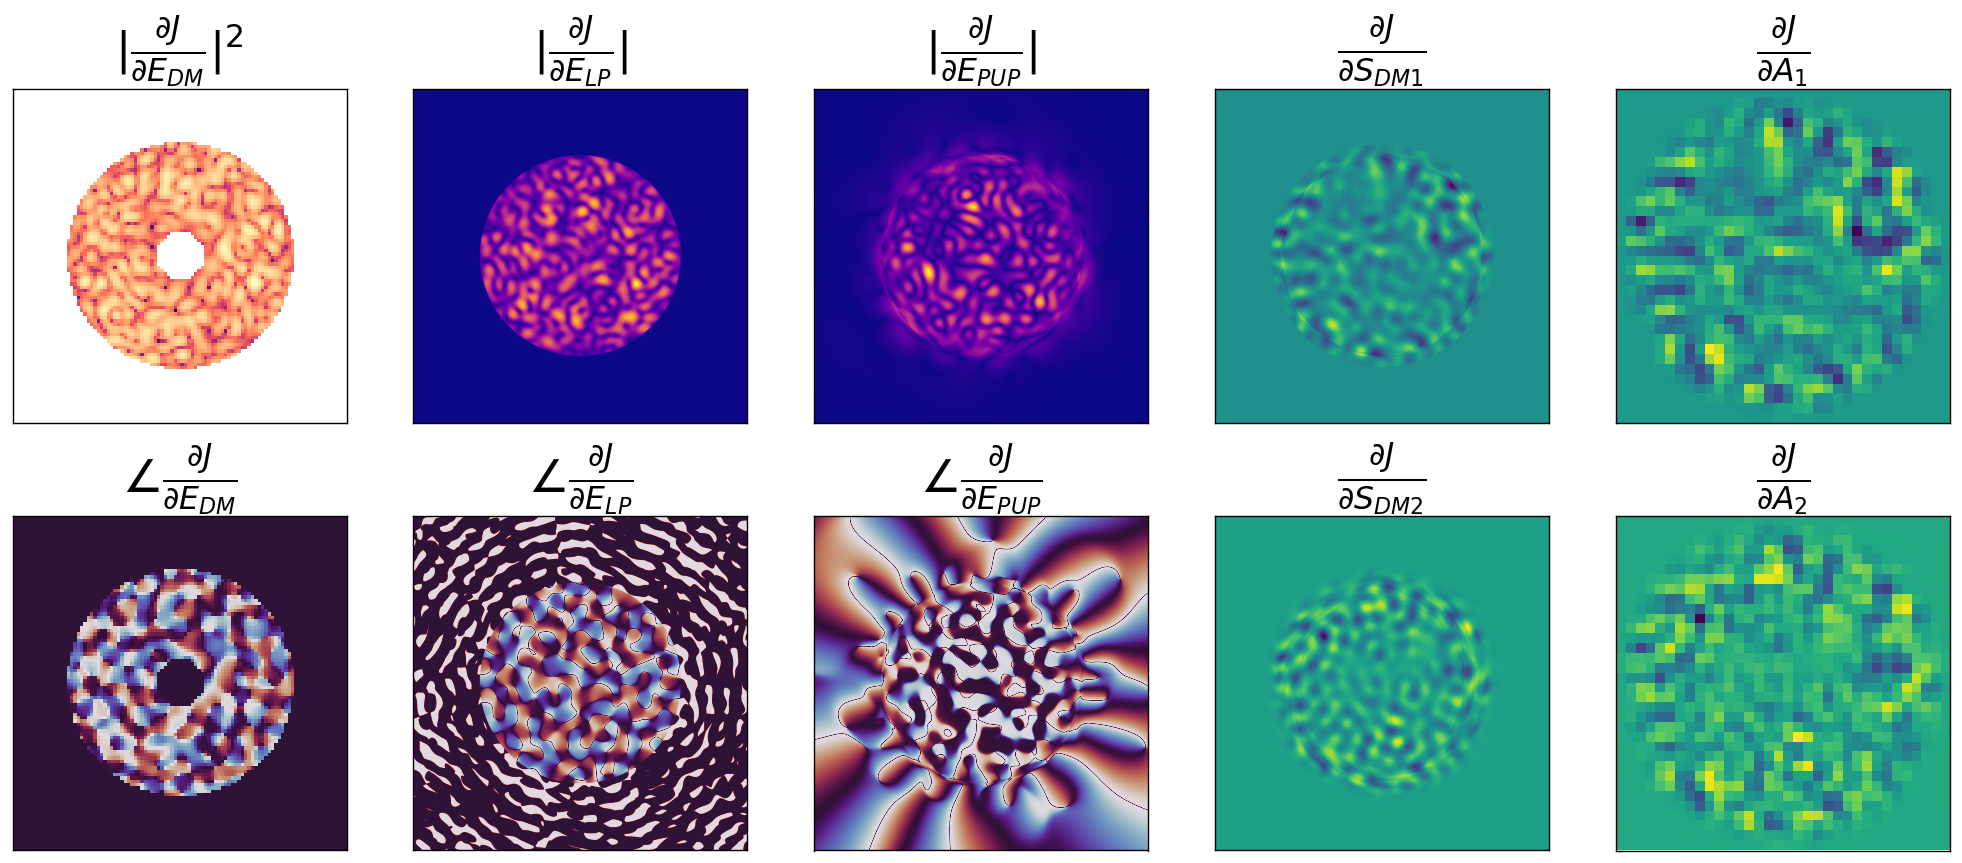

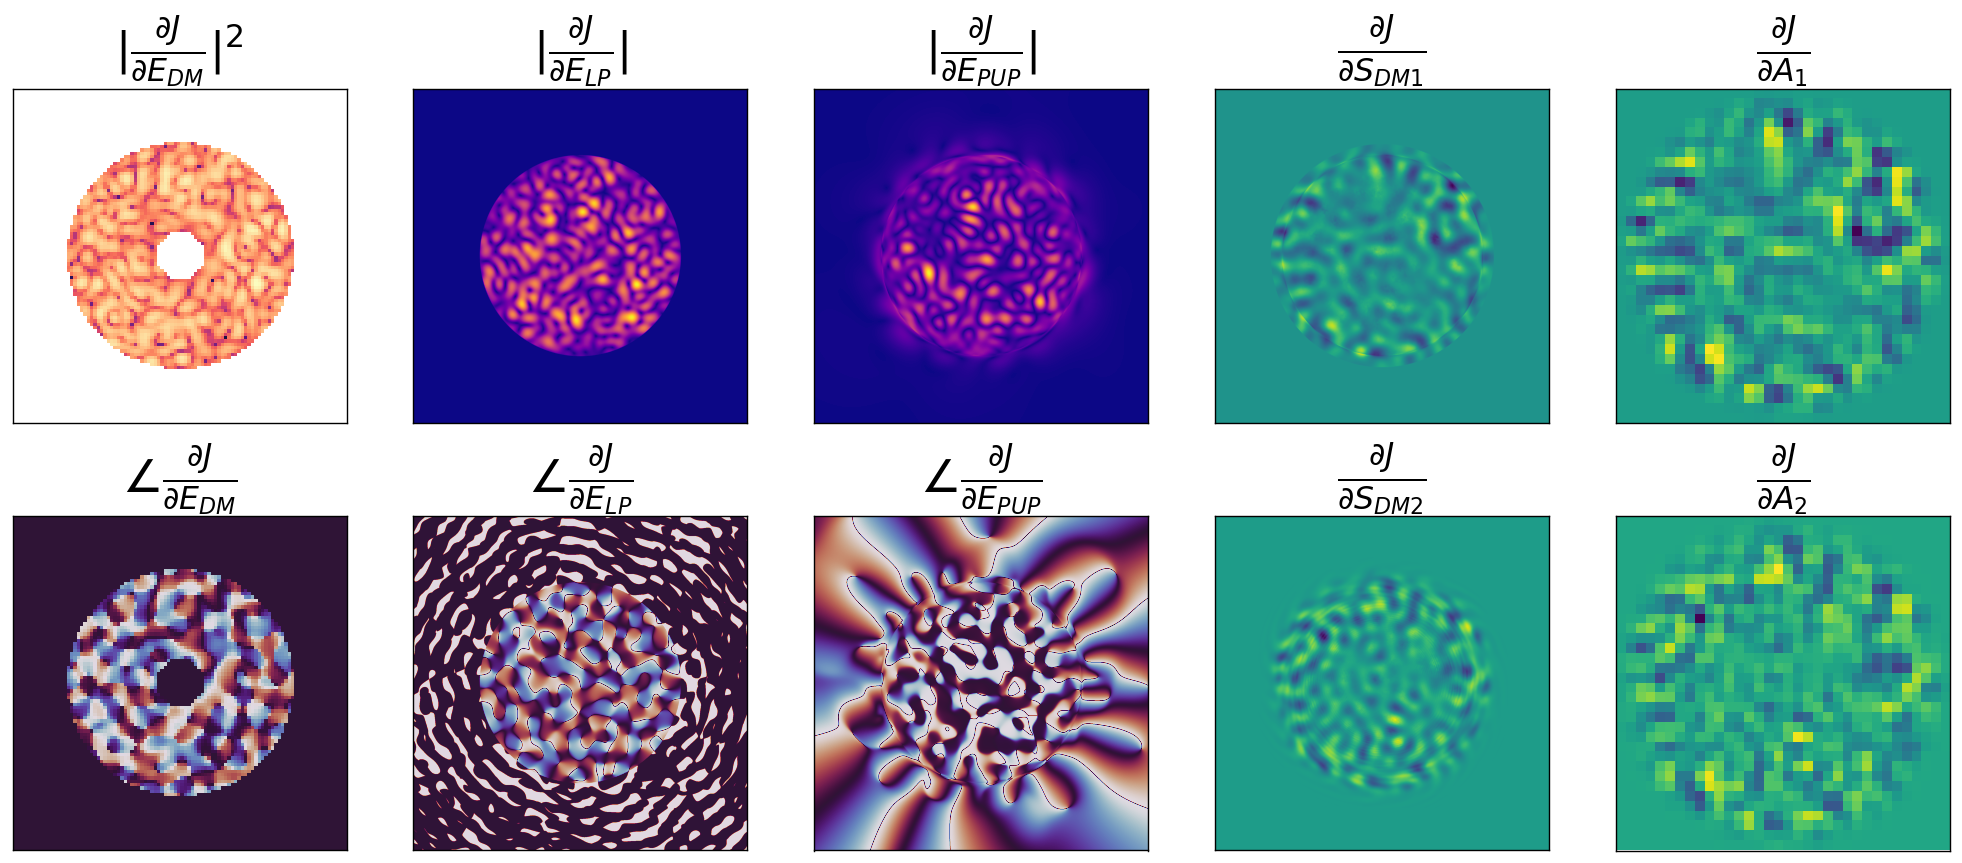

In [70]:
reload(fraunhofer)
from apra_pop_models import imshows
reload(imshows)
acts = xp.zeros(M.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.reset_dms()
I.add_dm1(fraunhofer.acts_to_command(acts[:M.Nacts//2], M.dm_mask))
I.add_dm2(fraunhofer.acts_to_command(acts[M.Nacts//2:], M.dm_mask))
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)
r_cond = 1e-3

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad_bb(del_acts, M, acts, E_abs, control_mask, est_waves, r_cond, 
                                        verbose=True, 
                                        # plot=True, 
                                        fancy_plot=True)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

In [71]:
reload(fraunhofer)

acts = xp.zeros(M.Nacts)
# acts = fits.getdata('ad_test_acts.fits')

I.reset_dms()
I.add_dm1(fraunhofer.acts_to_command(acts[:M.Nacts//2], M.dm_mask))
I.add_dm2(fraunhofer.acts_to_command(acts[M.Nacts//2:], M.dm_mask))
coro_im = I.snap()
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=0)

r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad_bb, 
    jac=True, 
    x0=del_acts0,
    args=(M, acts, E_abs, control_mask, est_waves, r_cond, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.37207D+07


 This problem is unconstrained.



At iterate    1    f=  7.91273D-01    |proj g|=  1.86835D+07

At iterate    2    f=  4.99978D-01    |proj g|=  6.07174D+06

At iterate    3    f=  4.12381D-01    |proj g|=  5.18157D+06

At iterate    4    f=  2.39656D-01    |proj g|=  5.25689D+06

At iterate    5    f=  1.95530D-01    |proj g|=  1.33190D+07

At iterate    6    f=  1.05508D-01    |proj g|=  3.00601D+06

At iterate    7    f=  9.26307D-02    |proj g|=  1.72719D+06

At iterate    8    f=  7.87640D-02    |proj g|=  1.90016D+06

At iterate    9    f=  6.24973D-02    |proj g|=  2.96651D+06

At iterate   10    f=  5.01013D-02    |proj g|=  3.30205D+06

At iterate   11    f=  3.95384D-02    |proj g|=  1.16253D+06

At iterate   12    f=  3.23531D-02    |proj g|=  1.33772D+06

At iterate   13    f=  2.65109D-02    |proj g|=  1.55595D+06

At iterate   14    f=  2.39234D-02    |proj g|=  2.39208D+06

At iterate   15    f=  1.91554D-02    |proj g|=  5.64035D+05

At iterate   16    f=  1.78118D-02    |proj g|=  5.66491D+05

At iter

1.832156444754296e-06 1.9670235256168162e-07


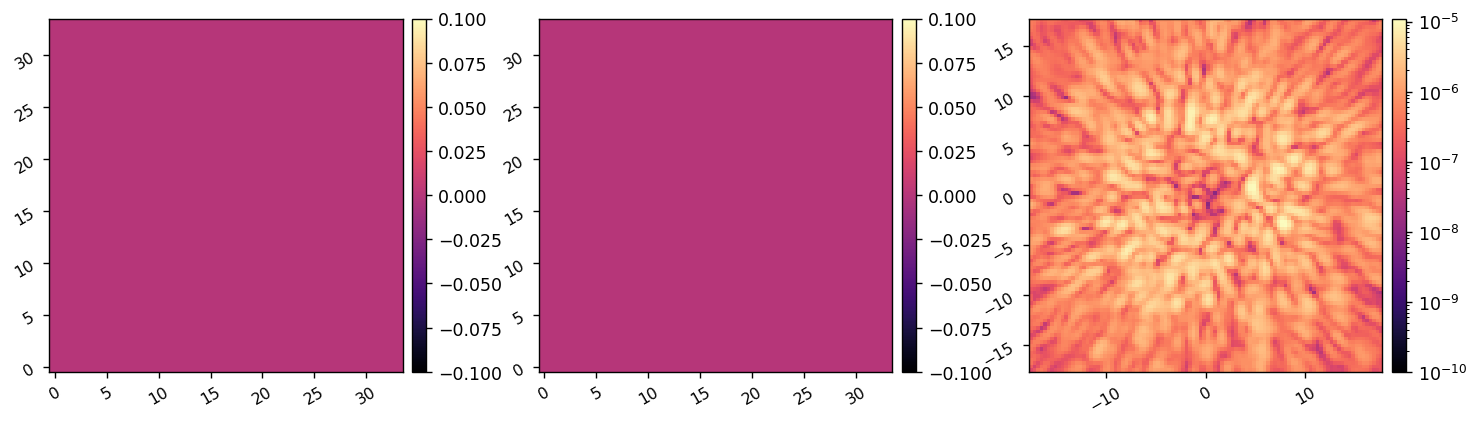

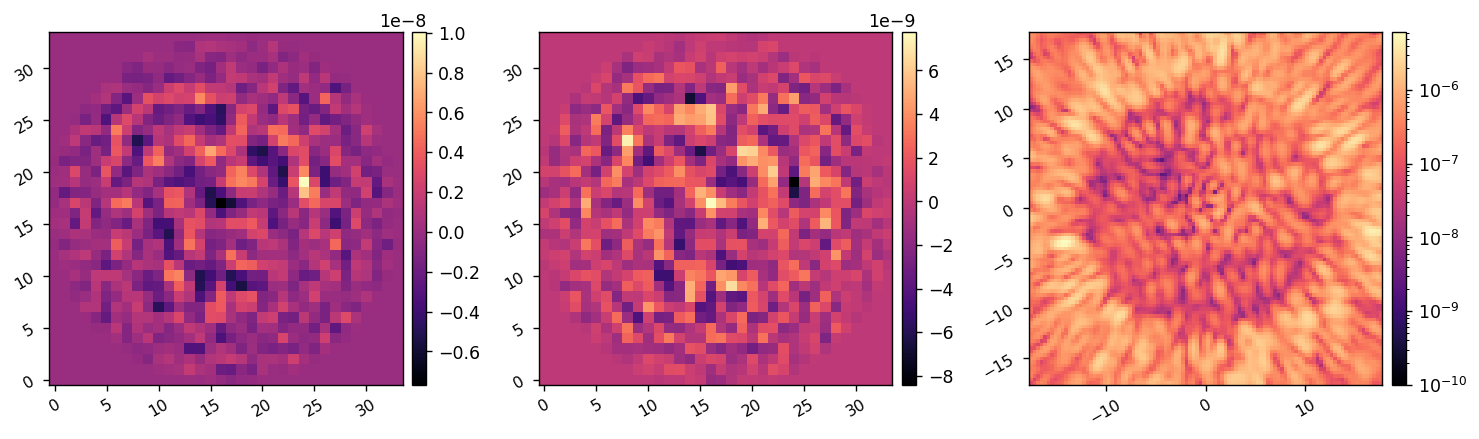

In [72]:
old_dm1 = fraunhofer.acts_to_command(acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.add_dm1(del_dm1)
I.add_dm2(del_dm2)
new_im = I.snap()

print(xp.mean(coro_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, coro_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
I.bandpasses

array([[6.17500e-07, 6.25625e-07, 6.33750e-07],
       [6.41875e-07, 6.50000e-07, 6.58125e-07],
       [6.66250e-07, 6.74375e-07, 6.82500e-07]])

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [89]:
I.reset_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.77736D+07


 This problem is unconstrained.



At iterate    1    f=  3.28556D-01    |proj g|=  1.18487D+07

At iterate    2    f=  1.63121D-01    |proj g|=  2.58554D+06

At iterate    3    f=  1.25133D-01    |proj g|=  1.97245D+06

At iterate    4    f=  9.33504D-02    |proj g|=  2.03886D+06

At iterate    5    f=  6.11821D-02    |proj g|=  2.72686D+06

At iterate    6    f=  5.65448D-02    |proj g|=  3.52641D+06

At iterate    7    f=  3.33091D-02    |proj g|=  8.85453D+05

At iterate    8    f=  2.80827D-02    |proj g|=  6.96732D+05

At iterate    9    f=  2.12322D-02    |proj g|=  7.70667D+05

At iterate   10    f=  1.65141D-02    |proj g|=  1.29200D+06

At iterate   11    f=  1.32351D-02    |proj g|=  5.80226D+05

At iterate   12    f=  1.16072D-02    |proj g|=  3.83054D+05

At iterate   13    f=  9.38311D-03    |proj g|=  4.10736D+05

At iterate   14    f=  7.79112D-03    |proj g|=  1.05485D+06

At iterate   15    f=  5.99222D-03    |proj g|=  5.20340D+05

At iterate   16    f=  4.98711D-03    |proj g|=  2.33387D+05

At iter

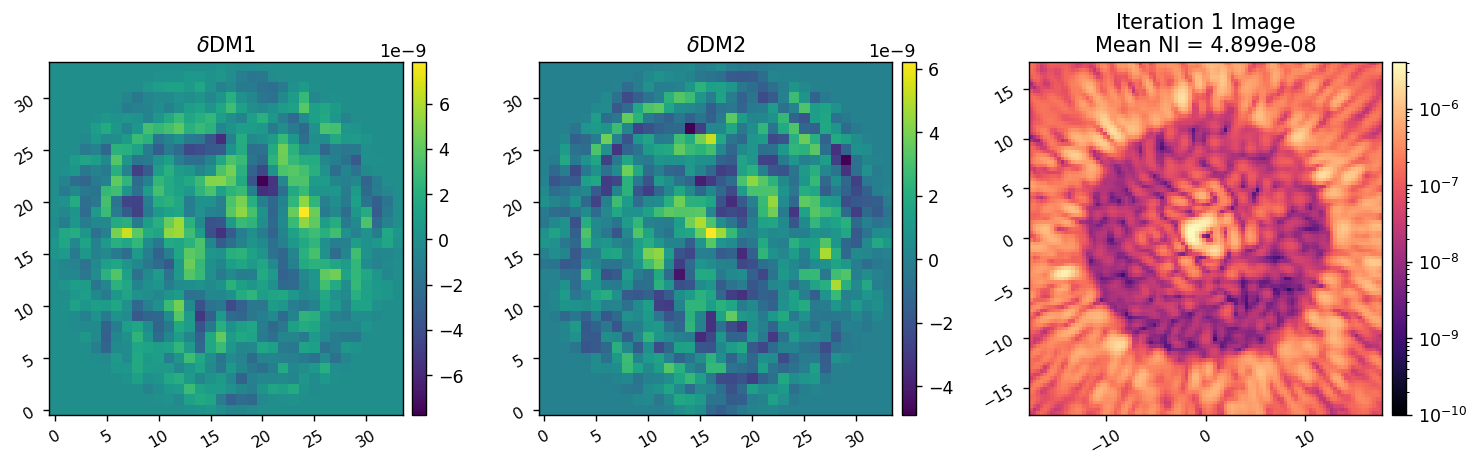

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.20684D+08


 This problem is unconstrained.



At iterate    1    f=  5.13170D-01    |proj g|=  7.88053D+07

At iterate    2    f=  3.93945D-01    |proj g|=  2.83078D+07

At iterate    3    f=  3.44133D-01    |proj g|=  2.02904D+07

At iterate    4    f=  2.92264D-01    |proj g|=  2.43494D+07

At iterate    5    f=  2.29033D-01    |proj g|=  3.55285D+07

At iterate    6    f=  2.05967D-01    |proj g|=  5.28970D+07

At iterate    7    f=  1.72594D-01    |proj g|=  1.16441D+07

At iterate    8    f=  1.62155D-01    |proj g|=  9.83990D+06

At iterate    9    f=  1.49425D-01    |proj g|=  1.26182D+07

At iterate   10    f=  1.38144D-01    |proj g|=  2.36963D+07

At iterate   11    f=  1.25618D-01    |proj g|=  8.13062D+06

At iterate   12    f=  1.19797D-01    |proj g|=  7.28879D+06

At iterate   13    f=  1.11265D-01    |proj g|=  9.22622D+06

At iterate   14    f=  1.08160D-01    |proj g|=  2.14109D+07

At iterate   15    f=  1.00257D-01    |proj g|=  7.38813D+06

At iterate   16    f=  9.62754D-02    |proj g|=  4.95580D+06

At iter

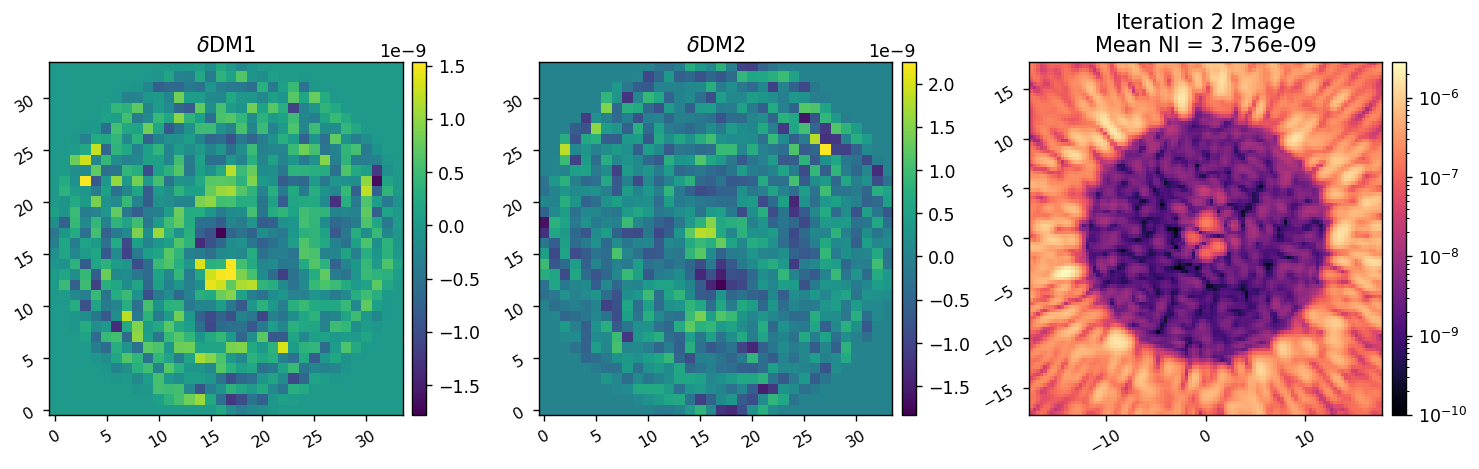

Running estimation algorithm ...
Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  3.51442D+08

At iterate    1    f=  7.63236D-01    |proj g|=  1.72729D+08

At iterate    2    f=  7.03106D-01    |proj g|=  8.82410D+07

At iterate    3    f=  6.66549D-01    |proj g|=  7.37044D+07

At iterate    4    f=  6.37042D-01    |proj g|=  8.23112D+07

At iterate    5    f=  6.14079D-01    |proj g|=  1.55245D+08

At iterate    6    f=  5.88787D-01    |proj g|=  5.04845D+07

At iterate    7    f=  5.80492D-01    |proj g|=  3.78136D+07

At iterate    8    f=  5.70861D-01    |proj g|=  3.88884D+07

At iterate    9    f=  5.68458D-01    |proj g|=  1.13507D+08

At iterate   10    f=  5.61019D-01    |proj g|=  2.67211D+07

At iterate   11    f=  5.58058D-01    |proj g|=  2.28835D+07

At iterate   12    f=  5.54461D-01    |proj g|=  2.93001D+07

At iterate   13    f=  5.4

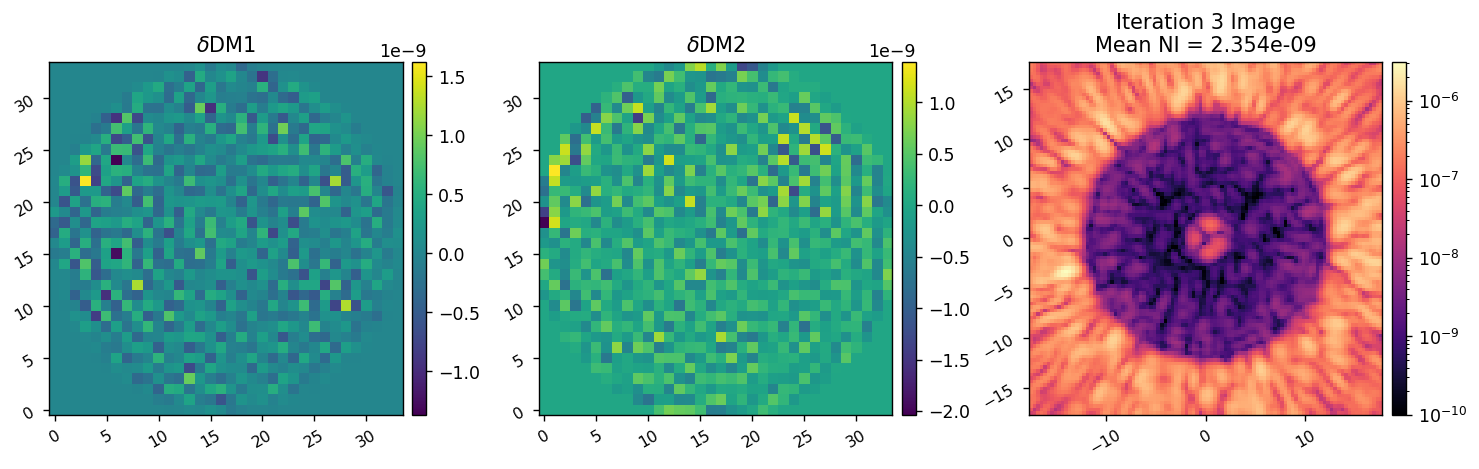

In [90]:
reload(fraunhofer)
reload(adefc)

r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    'maxls':100, 
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run_bb(
    I, 
    M, 
    fraunhofer.val_and_grad_bb, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)


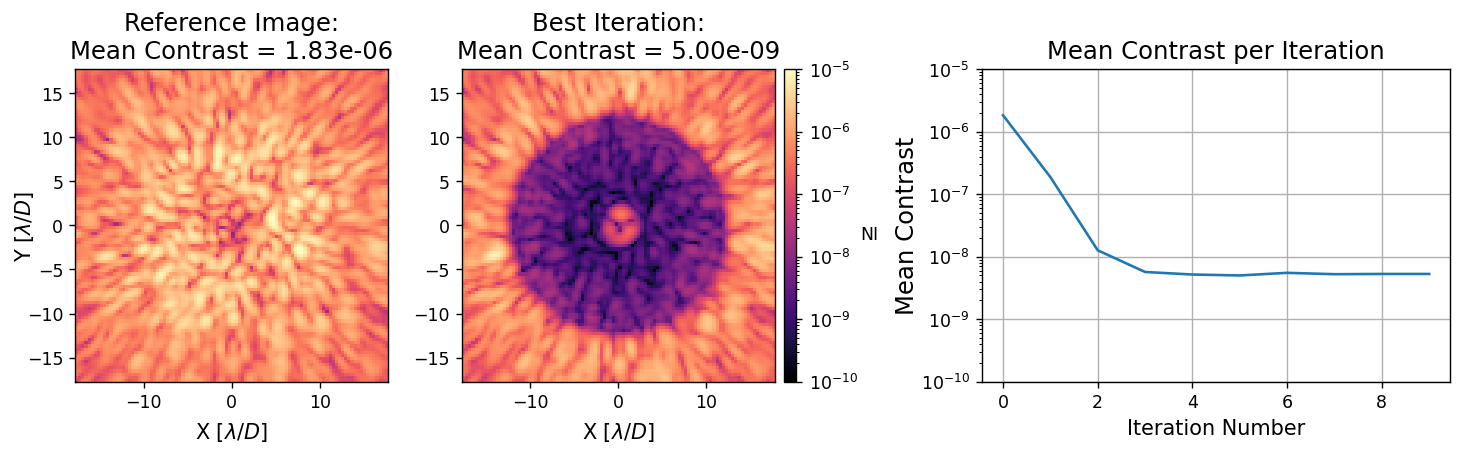

In [78]:
reload(adefc)
adefc.plot_data(data, vmax=1e-5)